In [ ]:
!pip install transformers

     |████████████████████████████████| 1.3MB 10.7MB/s 
     |████████████████████████████████| 890kB 38.0MB/s 
     |████████████████████████████████| 1.1MB 53.2MB/s 
     |████████████████████████████████| 2.9MB 55.9MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=1189544e1f3f58eb9539572e85eb1327760a9c804bd2104518de0d4b60a245d1
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
import os
import time
import datetime
from google.colab import drive

import pandas as pd
import seaborn as sns
import numpy as np
import random

import matplotlib.pyplot as plt
% matplotlib inline

import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler
torch.manual_seed(42)

from transformers import GPT2LMHeadModel,  GPT2Tokenizer, GPT2Config, GPT2LMHeadModel
from transformers import AdamW, get_linear_schedule_with_warmup

import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
!nvidia-smi

Sun Oct 25 16:43:30 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8     9W /  70W |     10MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive  
drive.mount(r'/content/drive/',force_remount=True) 

filename = 'shortjokes.csv'
data_dir = os.getcwd() + '/' + 'drive/My Drive/Colab Notebooks/NLP/Project/data'
data_dir

Mounted at /content/drive/


'/content/drive/My Drive/Colab Notebooks/NLP/Project/data'

In [ ]:
with open(data_dir + '/' + filename,'r') as f:
        # output = f.read().splitlines()
        df = pd.read_csv (f)  

In [ ]:
df = df[0:1000]

In [ ]:
df.dropna(inplace=True) #remove NA values
bios = df.Joke.copy() #just use the main bio text in this example
bios

0      [me narrating a documentary about narrators] "...
1      Telling my daughter garlic is good for you. Go...
2      I've been going through a really rough period ...
3      If I could have dinner with anyone, dead or al...
4         Two guys walk into a bar. The third guy ducks.
                             ...                        
995    I can't believe you "accidentally" let it slip...
996    One of my favourite things is Pork Souvlaki on...
997    New low: Looking in my purse and seeing my TV ...
998    If she's naming your wedding album on facebook...
999    Why do girls wear makeup and perfume? Because ...
Name: Joke, Length: 1000, dtype: object

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


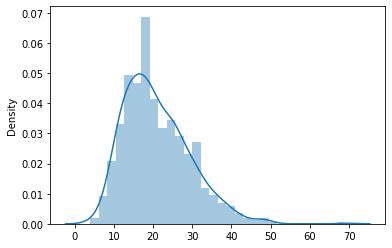

In [ ]:
doc_lengths = []

for bio in bios:

    # get rough token count distribution
    tokens = nltk.word_tokenize(bio)

    doc_lengths.append(len(tokens))

doc_lengths = np.array(doc_lengths)

sns.distplot(doc_lengths)

In [ ]:
# the max token length   
len(doc_lengths[doc_lengths > 768])/len(doc_lengths)

0.0

In [ ]:
np.average(doc_lengths)

20.927

In [ ]:
# Load the GPT tokenizer.
tokenizer = GPT2Tokenizer.from_pretrained('gpt2', bos_token='<|startoftext|>', eos_token='<|endoftext|>', pad_token='<|pad|>') #gpt2-medium

Special tokens have been added in the vocabulary, make sure the associated word embedding are fine-tuned or trained.


In [ ]:
print("The max model length is {} for this model, although the actual embedding size for GPT small is 768".format(tokenizer.model_max_length))
print("The beginning of sequence token {} token has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.bos_token_id), tokenizer.bos_token_id))
print("The end of sequence token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.eos_token_id), tokenizer.eos_token_id))
print("The padding token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.pad_token_id), tokenizer.pad_token_id))

The max model length is 1024 for this model, although the actual embedding size for GPT small is 768
The beginning of sequence token <|startoftext|> token has the id 50257
The end of sequence token <|endoftext|> has the id 50256
The padding token <|pad|> has the id 50258


In [ ]:
batch_size = 16

In [ ]:
class GPT2Dataset(Dataset):

  def __init__(self, txt_list, tokenizer, gpt2_type="gpt2", max_length=768):

    self.tokenizer = tokenizer
    self.input_ids = []
    self.attn_masks = []

    for txt in txt_list:

      encodings_dict = tokenizer('<|startoftext|>'+ txt + '<|endoftext|>', truncation=True, max_length=max_length, padding="max_length")

      self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
      self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))
    
  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx] 

In [ ]:
dataset = GPT2Dataset(bios, tokenizer, max_length=768)

# Split into training and validation sets
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

  900 training samples
  100 validation samples


In [ ]:
# Create the DataLoaders for our training and validation datasets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [ ]:
# I'm not really doing anything with the config buheret
configuration = GPT2Config.from_pretrained('gpt2', output_hidden_states=False)

# instantiate the model
model = GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)

# this step is necessary because I've added some tokens (bos_token, etc) to the embeddings
# otherwise the tokenizer and model tensors won't match up
model.resize_token_embeddings(len(tokenizer))

# Tell pytorch to run this model on the GPU.
device = torch.device("cuda")
model.cuda()

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
# some parameters I cooked up that work reasonably well

epochs = 5
learning_rate = 5e-4
warmup_steps = 1e2
epsilon = 1e-8

# this produces sample output every 100 steps
sample_every = 100

In [ ]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
optimizer = AdamW(model.parameters(),
                  lr = learning_rate,
                  eps = epsilon
                )

In [ ]:
# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
# This changes the learning rate as the training loop progresses
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = warmup_steps, 
                                            num_training_steps = total_steps)

In [ ]:
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

In [ ]:
total_t0 = time.time()

training_stats ``= []

model = model.to(device)

for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()        

        outputs = model(  b_input_ids,
                          labels=b_labels, 
                          attention_mask = b_masks,
                          token_type_ids=None
                        )

        loss = outputs[0]  

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every x batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}. Loss: {:>5,}.   Elapsed: {:}.'.format(step, len(train_dataloader), batch_loss, elapsed))

            model.eval()

            sample_outputs = model.generate(
                                    bos_token_id=random.randint(1,30000),
                                    do_sample=True,   
                                    top_k=50, 
                                    max_length = 200,
                                    top_p=0.95, 
                                    num_return_sequences=1
                                )
            for i, sample_output in enumerate(sample_outputs):
                  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))
            
            model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)       
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)
        
        with torch.no_grad():        

            outputs  = model(b_input_ids, 
#                            token_type_ids=None, 
                             attention_mask = b_masks,
                            labels=b_labels)
          
            loss = outputs[0]  
            
        batch_loss = loss.item()
        total_eval_loss += batch_loss        

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    validation_time = format_time(time.time() - t0)    

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 5 ========
Training...


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


  Batch   100  of    450. Loss: 0.2310916781425476.   Elapsed: 0:00:51.
0:  bipartisan" to have was.


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


  Batch   200  of    450. Loss: 0.1525421291589737.   Elapsed: 0:01:44.
0:  increasingWhat do you wish is the name of the girl that I'm carrying on this knife
 I'm going to stab your throat with a knife I don't know my name.


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


  Batch   300  of    450. Loss: 0.15869112312793732.   Elapsed: 0:02:40.
0: day. They are the two most "The Most"


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


  Batch   400  of    450. Loss: 0.19526749849319458.   Elapsed: 0:03:36.
0:  HangQ. And so I learned about the concept of " a sheep in prison " in the very early days"

  Average training loss: 0.75
  Training epoch took: 0:04:05

Running Validation...
  Validation Loss: 0.13
  Validation took: 0:00:09

======== Epoch 2 / 5 ========
Training...


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


  Batch   100  of    450. Loss: 0.12084237486124039.   Elapsed: 0:00:58.
0:  foodsHow did the fruit fall out of the sea? A fall from the sea. It was a cross.


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


  Batch   200  of    450. Loss: 0.08599710464477539.   Elapsed: 0:01:56.
0:  trailIf you want to make an Amazonian joke about "me in my house" click this button next to a picture of me with the same shirt It says "Oh Jesus"


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


  Batch   300  of    450. Loss: 0.1339922845363617.   Elapsed: 0:02:55.
0: intendHow do I get to Santa's Fair? I don't have a Santa in store at all.


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


  Batch   400  of    450. Loss: 0.09342551976442337.   Elapsed: 0:03:53.
0:  surroundWhen I eat, I don't have to wait until it comes around on me.

  Average training loss: 0.11
  Training epoch took: 0:04:22

Running Validation...
  Validation Loss: 0.13
  Validation took: 0:00:10

======== Epoch 3 / 5 ========
Training...


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


  Batch   100  of    450. Loss: 0.1097523421049118.   Elapsed: 0:00:58.
0:  reflexI can't hear myself screaming while walking along the grass.


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


  Batch   200  of    450. Loss: 0.08107930421829224.   Elapsed: 0:01:57.
0:  displayDid you hear about how the Black man at the bank robbed two women in India last year? They went to the hospital for a rape...


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


  Batch   300  of    450. Loss: 0.1306064873933792.   Elapsed: 0:02:55.
0:  pastorWhen I read The New York Times... I asked the magazine's official question: Who killed the first World Trade Center? Who did the terrorists win? Who did the terrorists win? I think we win.......


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


  Batch   400  of    450. Loss: 0.10260315239429474.   Elapsed: 0:03:54.
0:  illicitWhat do you call a bald porcupine with short eyes and hairy feet? The "Pit of Revenge"

  Average training loss: 0.09
  Training epoch took: 0:04:23

Running Validation...
  Validation Loss: 0.13
  Validation took: 0:00:10

======== Epoch 4 / 5 ========
Training...


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


  Batch   100  of    450. Loss: 0.0742836743593216.   Elapsed: 0:00:58.
0:  LiberationQ: What did you tell the terrorists? A: I beat up a MAN.


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


  Batch   200  of    450. Loss: 0.1080985814332962.   Elapsed: 0:01:56.
0:  NamA guy dressed as a rabbi walked into my house with a flashlight. My dad just said, "Shit!" And he was gone.


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


  Batch   300  of    450. Loss: 0.07915031164884567.   Elapsed: 0:02:55.
0: IONThis is my account of how I hid the bathroom doorbell.  Bellhop, I'm traveling with my girlfriend.  Bellhop manager: "Shit! We're looking for you, we have a problem"


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


  Batch   400  of    450. Loss: 0.06749794632196426.   Elapsed: 0:03:53.
0:  glimpseBuddy Boner: Why don't you two start by sending me some bacon

  Average training loss: 0.07
  Training epoch took: 0:04:22

Running Validation...
  Validation Loss: 0.14
  Validation took: 0:00:10

======== Epoch 5 / 5 ========
Training...


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


  Batch   100  of    450. Loss: 0.05852168798446655.   Elapsed: 0:00:58.
0:  LaureA guy was talking to me When I asked what he wanted... He said it was a gun He said he could not ask me to his bank account unless I said I have a gun.


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


  Batch   200  of    450. Loss: 0.03686672821640968.   Elapsed: 0:01:57.
0: ismWhen someone yells in a Mexican accent and I'm pretty sure he's talking to a police dog, I'll shoot the dog right there.


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


  Batch   300  of    450. Loss: 0.048955198377370834.   Elapsed: 0:02:55.
0: oun"Boyfriend? Where the fuck is your car?!" "I don't know" "Because my sister used it on her Grandma's Grandma's Grandma's car" "Oh shit, dad! That's where dad got his fucking keys!"


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


  Batch   400  of    450. Loss: 0.06867243349552155.   Elapsed: 0:03:54.
0:  electionI like my chicken nuggets too much, I highly suggest they be high in Cumin. I was given these for my Father's Day.

  Average training loss: 0.06
  Training epoch took: 0:04:23

Running Validation...
  Validation Loss: 0.15
  Validation took: 0:00:10

Training complete!
Total training took 0:22:24 (h:mm:ss)


In [ ]:
# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Training Time,Validation Time
epoch,,,,
1,0.75,0.13,0:04:05,0:00:09
2,0.11,0.13,0:04:22,0:00:10
3,0.09,0.13,0:04:23,0:00:10
4,0.07,0.14,0:04:22,0:00:10
5,0.06,0.15,0:04:23,0:00:10


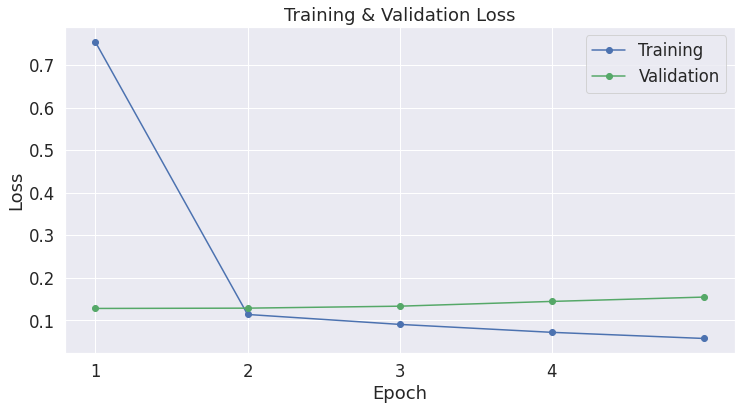

In [ ]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [ ]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The GPT-2 model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:2]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[2:14]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-2:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The GPT-2 model has 148 different named parameters.

==== Embedding Layer ====

transformer.wte.weight                                  (50259, 768)
transformer.wpe.weight                                   (1024, 768)

==== First Transformer ====

transformer.h.0.ln_1.weight                                   (768,)
transformer.h.0.ln_1.bias                                     (768,)
transformer.h.0.attn.c_attn.weight                       (768, 2304)
transformer.h.0.attn.c_attn.bias                             (2304,)
transformer.h.0.attn.c_proj.weight                        (768, 768)
transformer.h.0.attn.c_proj.bias                              (768,)
transformer.h.0.ln_2.weight                                   (768,)
transformer.h.0.ln_2.bias                                     (768,)
transformer.h.0.mlp.c_fc.weight                          (768, 3072)
transformer.h.0.mlp.c_fc.bias                                (3072,)
transformer.h.0.mlp.c_proj.weight                        (3072

In [ ]:
model.eval()

prompt = "<|startoftext|>"

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

print(generated)

sample_outputs = model.generate(
                                generated, 
                                #bos_token_id=random.randint(1,30000),
                                do_sample=True,   
                                top_k=50, 
                                max_length = 300,
                                top_p=0.95, 
                                num_return_sequences=3
                                )

for i, sample_output in enumerate(sample_outputs):
  print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


tensor([[50257]], device='cuda:0')
0: A hawk snatched my gf's chihuahua today... Now it's ready for me!


1: I got pregnant from a needle of mystery, which explains why I'm the only one with a twin.


2: How many Freudians does it take to change a lightbulb? None.




In [ ]:
model.eval()

prompt = "<|startoftext|>"

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

print(generated)

sample_outputs = model.generate(
                                generated, 
                                #bos_token_id=random.randint(1,30000),
                                do_sample=True,   
                                top_k=50, 
                                max_length = 300,
                                top_p=0.95, 
                                num_return_sequences=3
                                )

for i, sample_output in enumerate(sample_outputs):
  print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

NameError: ignored

In [ ]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')

In [ ]:
from transformers import BertForSequenceClassification

model_sec = BertForSequenceClassification.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', return_dict=True)
inputs = tokenizer("Hello, my dog is cute", return_tensors="pt")
labels = torch.tensor([1]).unsqueeze(0)  # Batch size 1
outputs = model(**inputs, labels=labels)
loss = outputs.loss
logits = outputs.logits

outputs

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

SequenceClassifierOutput([('loss', tensor(0.7760, grad_fn=<NllLossBackward>)),
                          ('logits',
                           tensor([[-0.0180, -0.1773]], grad_fn=<AddmmBackward>))])

In [ ]:
from transformers import BertTokenizer, BertForNextSentencePrediction
import torch
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForNextSentencePrediction.from_pretrained('bert-base-uncased', return_dict=True)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForNextSentencePrediction: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
prompt = "In Italy, pizza served in formal settings, such as at a restaurant, is presented unsliced."
next_sentence = 'And you can eat it however you want' #"The sky is blue due to the shorter wavelength of blue light."
encoding = tokenizer(prompt, next_sentence, return_tensors='pt')
outputs = model(**encoding, next_sentence_label=torch.LongTensor([1]))
logits = outputs.logits

print(outputs)
'Was the next sentence random? ',(logits[0, 0] < logits[0, 1]), (logits[0, 0] - logits[0, 1]), 


NextSentencePredictorOutput(loss=tensor(7.9562, grad_fn=<NllLossBackward>), logits=tensor([[ 4.4104, -3.5455]], grad_fn=<AddmmBackward>), hidden_states=None, attentions=None)


('Was the next sentence random? ',
 tensor(False),
 tensor(7.9559, grad_fn=<SubBackward0>))

In [ ]:
prompt = "In Italy, pizza served in formal settings, such as at a restaurant, is presented unsliced."
next_sentence = "The sky is blue due to the shorter wavelength of blue light."
encoding = tokenizer(prompt, next_sentence, return_tensors='pt')
outputs = model(**encoding, next_sentence_label=torch.LongTensor([1]))
logits = outputs.logits


outputs, '\nWas the next sentence random? ',(logits[0, 0] < logits[0, 1]), (logits[0, 0] - logits[0, 1]), 


(NextSentencePredictorOutput([('loss',
                               tensor(0.0001, grad_fn=<NllLossBackward>)),
                              ('logits',
                               tensor([[-3.0729,  5.9056]], grad_fn=<AddmmBackward>))]),
 '\nWas the next sentence random? ',
 tensor(True),
 tensor(-8.9786, grad_fn=<SubBackward0>))